In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [77]:
# old decoder
old_decoder_casp = pd.read_csv("benchmark_data/final_1_casp/final_1_casp_scores.csv")
old_decoder_test = pd.read_csv("benchmark_data/final_1_test/final_1_test_scores.csv")

# prime darkness
# prime_darkness_casp = pd.read_csv("benchmark_data/prime_darkness_1_casp/prime_darkness_1_casp_scores.csv")
# prime_darkness_test = pd.read_csv("benchmark_data/prime_darkness_1_test/prime_darkness_1_test_scores.csv")

# beta = 0
beta_0_casp = pd.read_csv("benchmark_data/final_final_1_casp/final_final_1_casp_scores.csv")
beta_0_test = pd.read_csv("benchmark_data/final_final_1_test/final_final_1_test_scores.csv")

# beta = 1
beta_1_casp = pd.read_csv("benchmark_data/final_final_2_casp/final_final_2_casp_scores.csv")
beta_1_test = pd.read_csv("benchmark_data/final_final_2_test/final_final_2_test_scores.csv")

# bio2token
bio2token_casp = pd.read_csv("benchmark_data/bio2token_1_casp/bio2token_1_casp_scores.csv")
bio2token_test = pd.read_csv("benchmark_data/bio2token_1_test/bio2token_1_test_scores.csv")

# foldtoken
foldtoken_casp = pd.read_csv("benchmark_data/foldtoken_1_casp/foldtoken_1_casp_scores.csv")
foldtoken_test = pd.read_csv("benchmark_data/foldtoken_1_test/foldtoken_1_test_scores.csv")

# esmfold
esmfold_casp = pd.read_csv("benchmark_data/ESMFold_casp/ESMFold_casp_scores.csv")
esmfold_test = pd.read_csv("benchmark_data/ESMFold_test/ESMFold_test_scores.csv")

# prostt5 finalfinal model
prostt5_casp = pd.read_csv("benchmark_data/prostt5_1_casp/prostt5_1_casp_scores.csv")
prostt5_test = pd.read_csv("benchmark_data/prostt5_1_test/prostt5_1_test_scores.csv")

In [78]:
# Define the bootstrapping function
def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    lower = np.percentile(means, (1 - ci) / 2 * 100)
    upper = np.percentile(means, (1 + ci) / 2 * 100)
    return np.mean(means), lower, upper

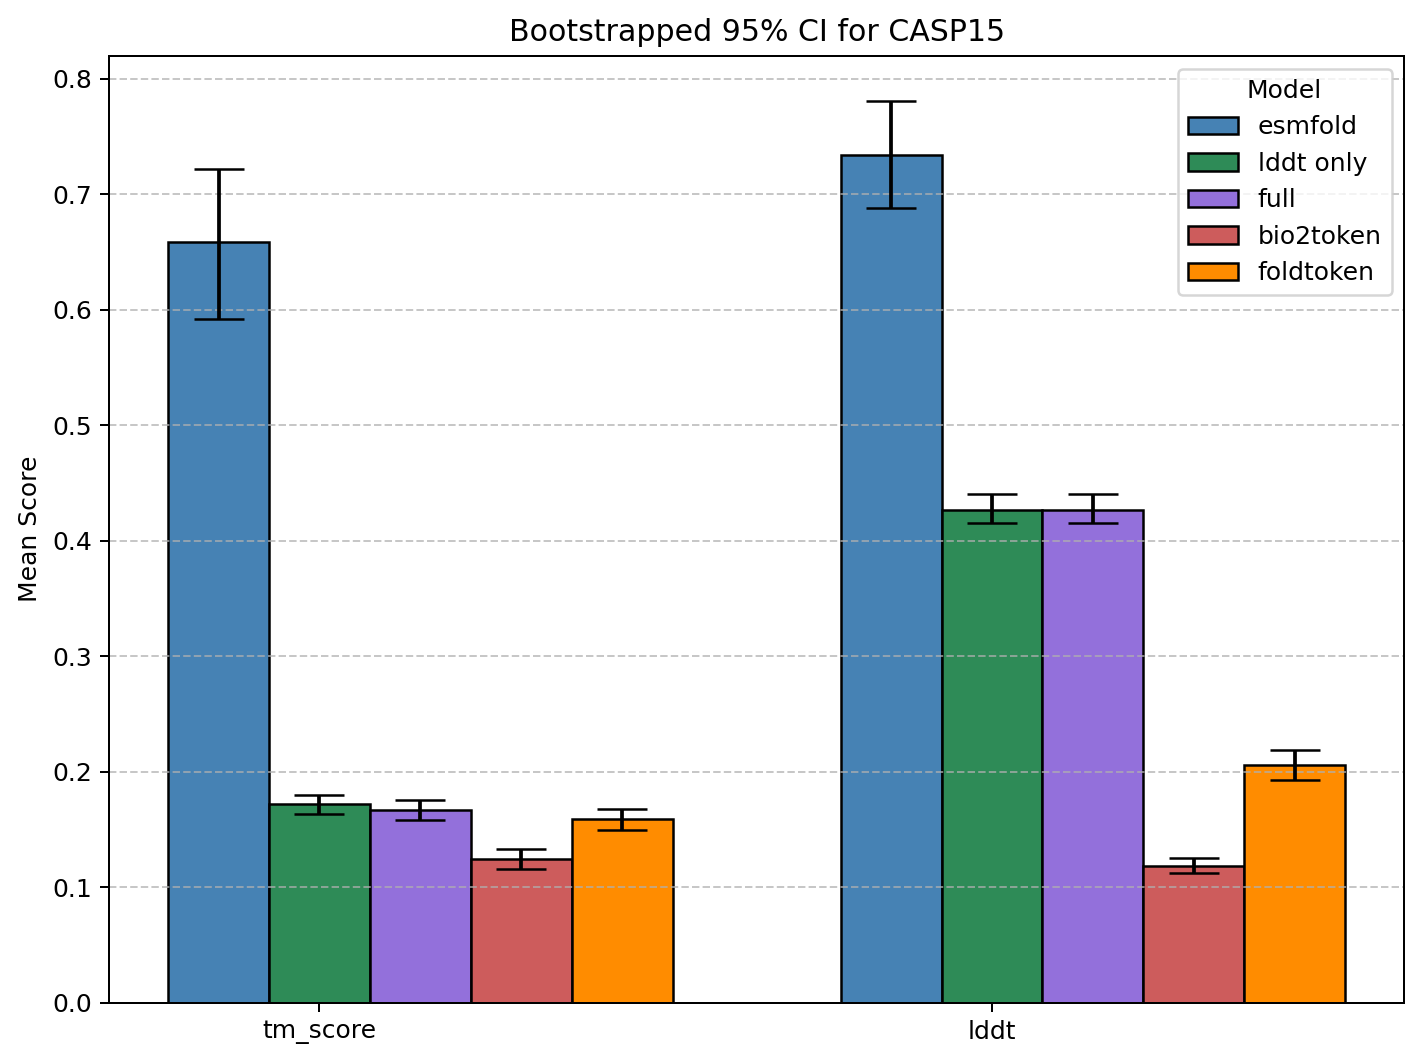

In [79]:
dfs = [esmfold_casp, beta_0_casp, beta_1_casp, bio2token_casp, foldtoken_casp]
model_names = ["esmfold", "lddt only", "full", "bio2token", "foldtoken"]
metrics = ['tm_score', 'lddt']

all_results = {}

for model_name, df in zip(model_names, dfs):
    results = {}
    for col in metrics:
        data = df[col].dropna().values
        mean, lower, upper = bootstrap_ci(data)
        results[col] = {
            'mean': mean,
            'lower_ci': lower,
            'upper_ci': upper
        }
    all_results[model_name] = results

# Vorbereitung für grouped bar plot
means = np.array([[all_results[model][metric]['mean'] for metric in metrics] for model in model_names])
errors = np.array([
    [
        (
            all_results[model][metric]['mean'] - all_results[model][metric]['lower_ci'],
            all_results[model][metric]['upper_ci'] - all_results[model][metric]['mean']
        )
        for metric in metrics
    ]
    for model in model_names
])
# yerr muss in Form (2, model, metric) sein
yerr = np.transpose(errors, (2, 0, 1))  # (low/high, model, metric)

# Plot
x = np.arange(len(metrics))
width = 0.15

plt.figure(figsize=(8, 6), dpi=180)

colors = ['steelblue','seagreen', 'mediumpurple', 'indianred', 'darkorange']
for i, (model, color) in enumerate(zip(model_names, colors)):
    plt.bar(
        x + i * width,
        means[i],
        yerr=[yerr[0][i], yerr[1][i]],
        capsize=10,
        width=width,
        label=model,
        edgecolor='black',
        color=color
    )

plt.xticks(x + width, metrics)
plt.ylabel("Mean Score")
#plt.ylim(0, 1)
plt.title("Bootstrapped 95% CI for CASP15")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


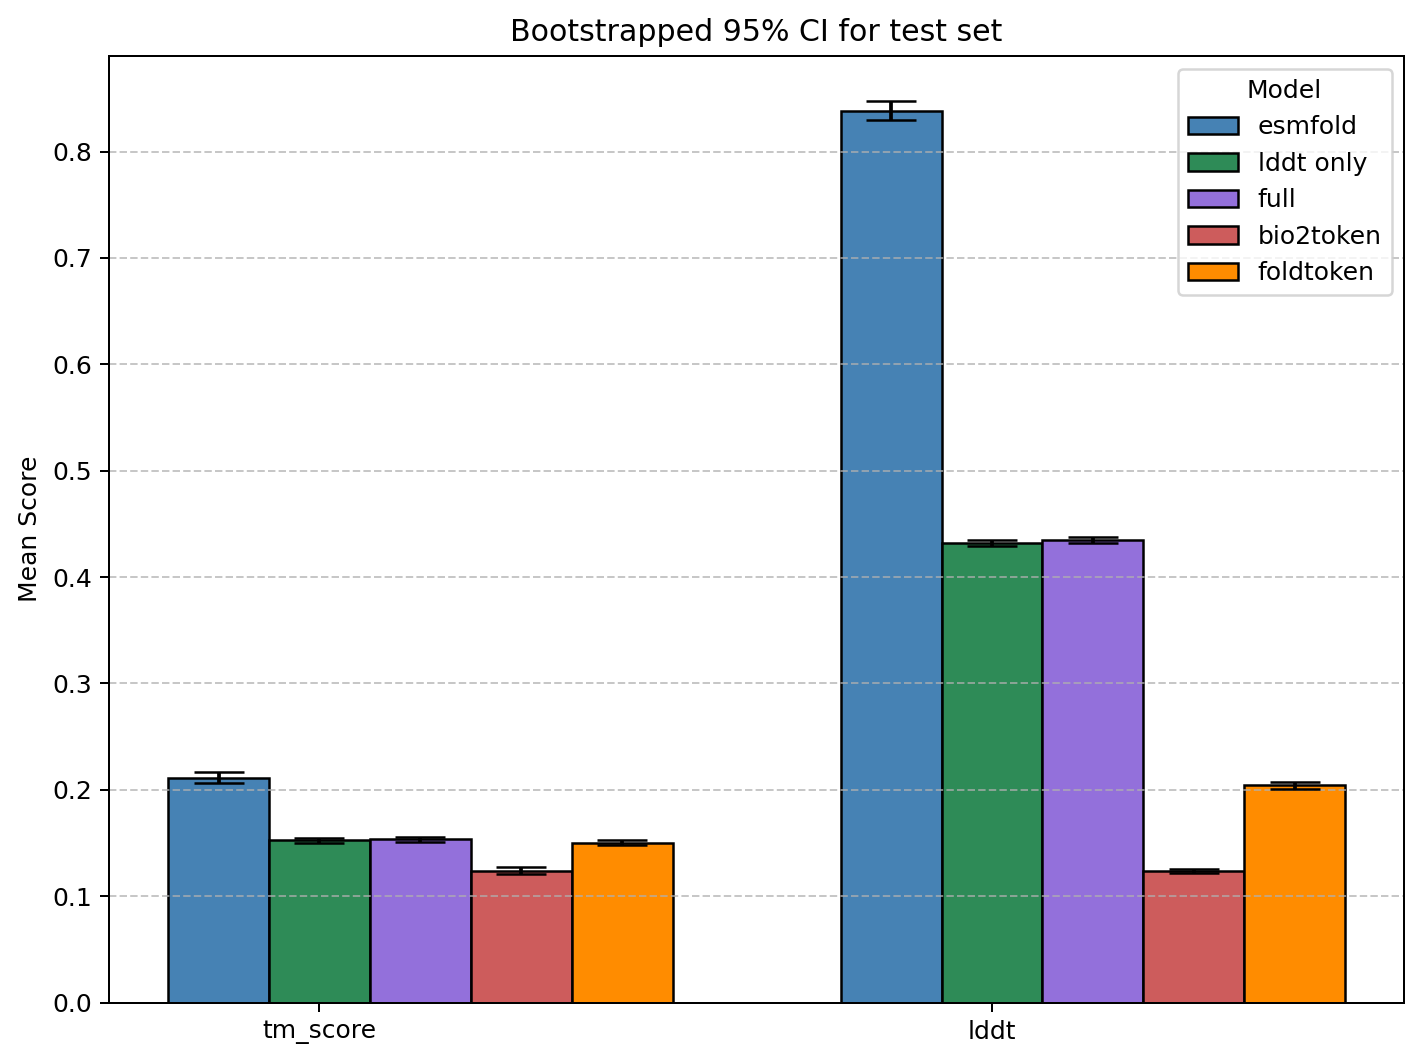

In [80]:
dfs = [esmfold_test, beta_0_test, beta_1_test, bio2token_test, foldtoken_test]
model_names = ["esmfold", "lddt only", "full", "bio2token", "foldtoken"]
metrics = ['tm_score', 'lddt']

all_results = {}

for model_name, df in zip(model_names, dfs):
    results = {}
    for col in metrics:
        data = df[col].dropna().values
        mean, lower, upper = bootstrap_ci(data)
        results[col] = {
            'mean': mean,
            'lower_ci': lower,
            'upper_ci': upper
        }
    all_results[model_name] = results

# Vorbereitung für grouped bar plot
means = np.array([[all_results[model][metric]['mean'] for metric in metrics] for model in model_names])
errors = np.array([
    [
        (
            all_results[model][metric]['mean'] - all_results[model][metric]['lower_ci'],
            all_results[model][metric]['upper_ci'] - all_results[model][metric]['mean']
        )
        for metric in metrics
    ]
    for model in model_names
])
# yerr muss in Form (2, model, metric) sein
yerr = np.transpose(errors, (2, 0, 1))  # (low/high, model, metric)

# Plot
x = np.arange(len(metrics))
width = 0.15

plt.figure(figsize=(8, 6), dpi=180)

colors = ['steelblue','seagreen', 'mediumpurple', 'indianred', 'darkorange']
for i, (model, color) in enumerate(zip(model_names, colors)):
    plt.bar(
        x + i * width,
        means[i],
        yerr=[yerr[0][i], yerr[1][i]],
        capsize=10,
        width=width,
        label=model,
        edgecolor='black',
        color=color
    )

plt.xticks(x + width, metrics)
plt.ylabel("Mean Score")
#plt.ylim(0, 1)
plt.title("Bootstrapped 95% CI for test set")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


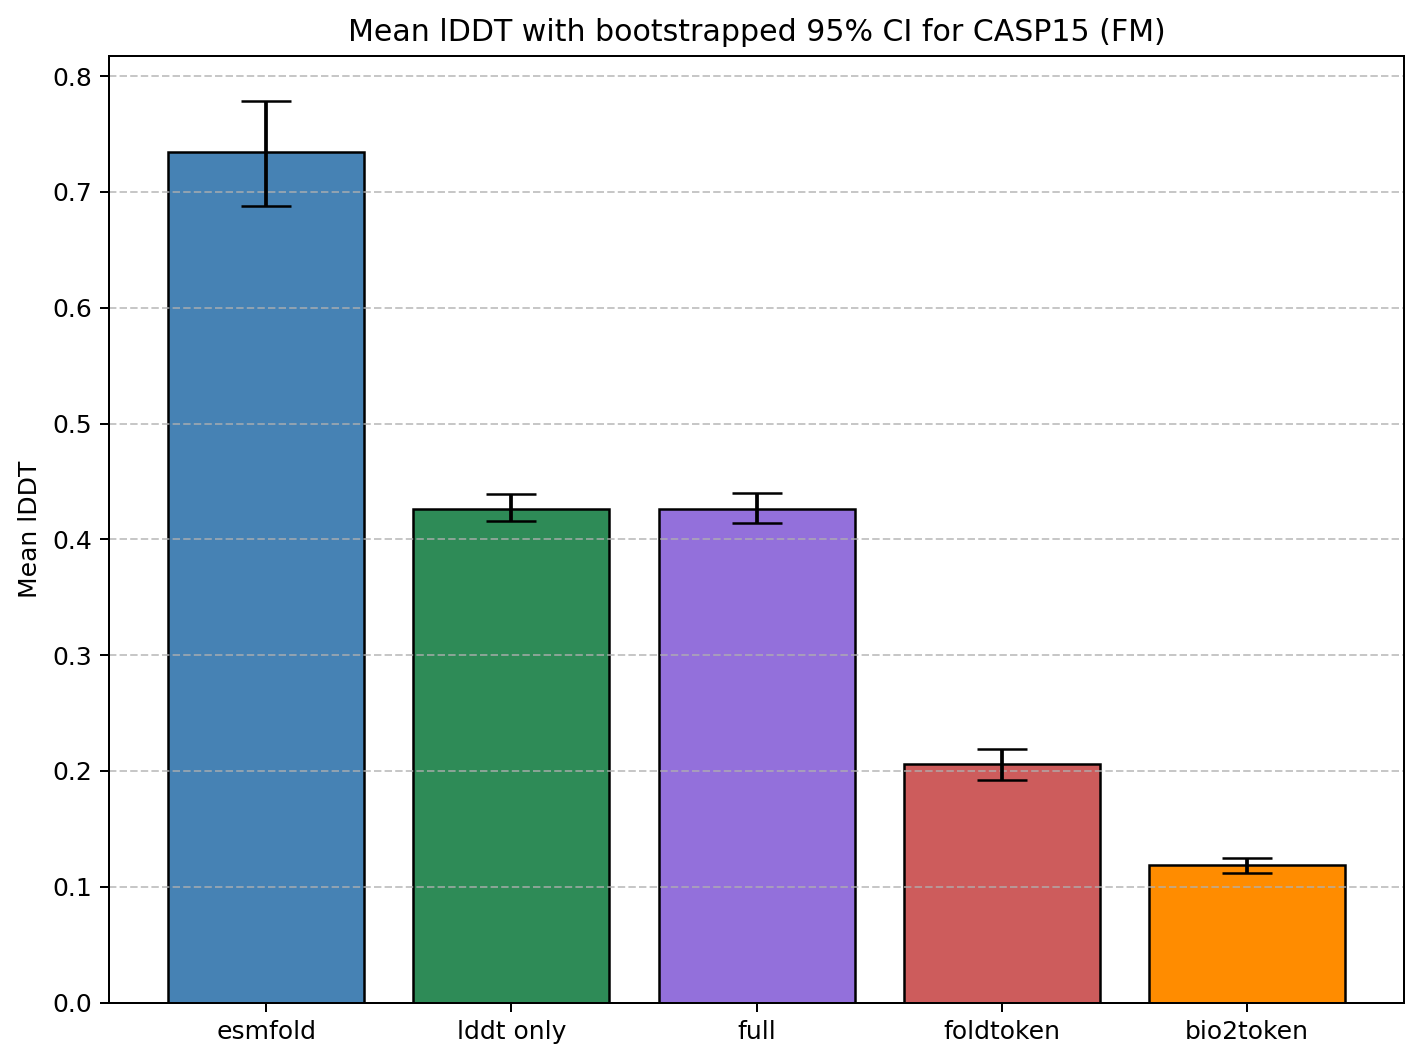

In [81]:
dfs = [esmfold_casp, beta_0_casp, beta_1_casp, foldtoken_casp, bio2token_casp]
model_names = ["esmfold", "lddt only", "full", "foldtoken", "bio2token"]

all_results = {}

for model_name, df in zip(model_names, dfs):
    results = {}
    for col in metrics:
        data = df[col].dropna().values
        mean, lower, upper = bootstrap_ci(data)
        results[col] = {
            'mean': mean,
            'lower_ci': lower,
            'upper_ci': upper
        }
    all_results[model_name] = results


# Vorbereitung für grouped bar plot
means = np.array([[all_results[model][metric]['mean'] for metric in metrics] for model in model_names])
errors = np.array([
    [
        (
            all_results[model][metric]['mean'] - all_results[model][metric]['lower_ci'],
            all_results[model][metric]['upper_ci'] - all_results[model][metric]['mean']
        )
        for metric in metrics
    ]
    for model in model_names
])


means = [all_results[model]['lddt']['mean'] for model in model_names]
lower_ci = [all_results[model]['lddt']['lower_ci'] for model in model_names]
upper_ci = [all_results[model]['lddt']['upper_ci'] for model in model_names]

yerr = np.array([
    [mean - low for mean, low in zip(means, lower_ci)],
    [up - mean for up, mean in zip(upper_ci, means)]
])


# Plot
x = np.arange(len(model_names))
plt.figure(figsize=(8, 6), dpi=180)

colors = ['steelblue','seagreen', 'mediumpurple', 'indianred', 'darkorange']

plt.bar(
    x,
    means,
    yerr=yerr,
    capsize=10,
    color=colors,
    edgecolor='black'
)

plt.xticks(x, model_names)
plt.ylabel("Mean lDDT")
#plt.ylim(0, 1)
plt.title("Mean lDDT with bootstrapped 95% CI for CASP15 (FM)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plots/lddt_ci_per_model.png")
plt.show()


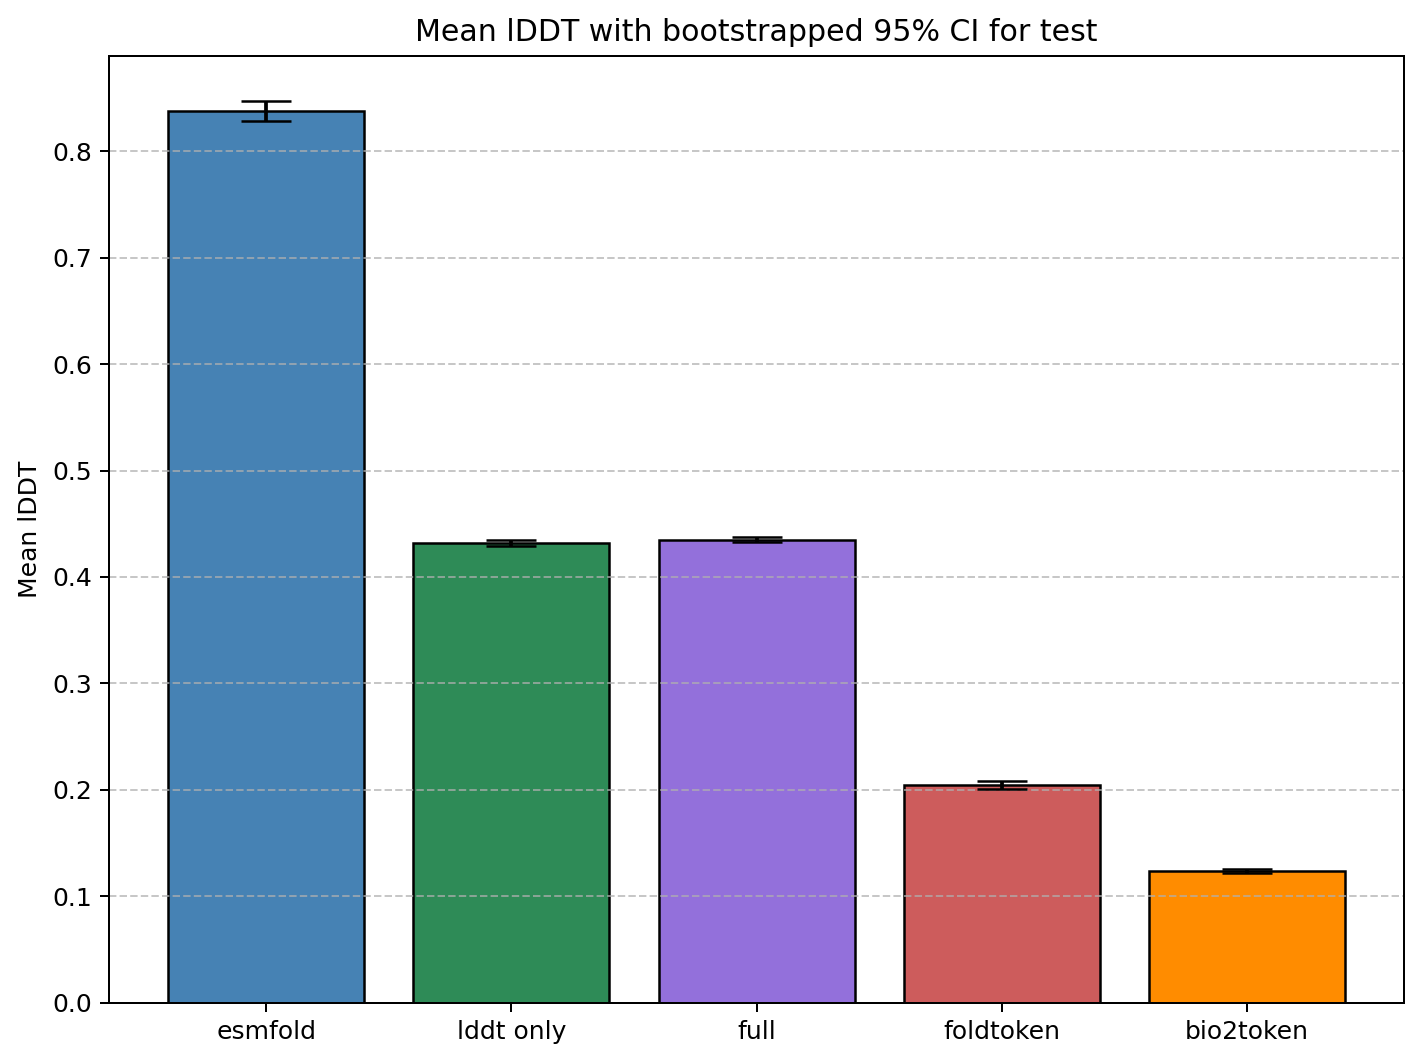

In [82]:
dfs = [esmfold_test, beta_0_test, beta_1_test, foldtoken_test, bio2token_test]
model_names = ["esmfold", "lddt only", "full", "foldtoken", "bio2token"]

all_results = {}

for model_name, df in zip(model_names, dfs):
    results = {}
    for col in metrics:
        data = df[col].dropna().values
        mean, lower, upper = bootstrap_ci(data)
        results[col] = {
            'mean': mean,
            'lower_ci': lower,
            'upper_ci': upper
        }
    all_results[model_name] = results


# Vorbereitung für grouped bar plot
means = np.array([[all_results[model][metric]['mean'] for metric in metrics] for model in model_names])
errors = np.array([
    [
        (
            all_results[model][metric]['mean'] - all_results[model][metric]['lower_ci'],
            all_results[model][metric]['upper_ci'] - all_results[model][metric]['mean']
        )
        for metric in metrics
    ]
    for model in model_names
])


means = [all_results[model]['lddt']['mean'] for model in model_names]
lower_ci = [all_results[model]['lddt']['lower_ci'] for model in model_names]
upper_ci = [all_results[model]['lddt']['upper_ci'] for model in model_names]

yerr = np.array([
    [mean - low for mean, low in zip(means, lower_ci)],
    [up - mean for up, mean in zip(upper_ci, means)]
])


# Plot
x = np.arange(len(model_names))
plt.figure(figsize=(8, 6), dpi=180)

colors = ['steelblue','seagreen', 'mediumpurple', 'indianred', 'darkorange']

plt.bar(
    x,
    means,
    yerr=yerr,
    capsize=10,
    color=colors,
    edgecolor='black'
)

plt.xticks(x, model_names)
plt.ylabel("Mean lDDT")
#plt.ylim(0, 1)
plt.title("Mean lDDT with bootstrapped 95% CI for test")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plots/lddt_ci_per_model.png")
plt.show()
